In [42]:
# preprocessing 
#importing libraries

import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import NoNorm
from skimage import io, color, measure
import math
import copy

In [2]:
#importing the image

img = cv2.imread(r"/Users/rapetisiddhuneehal/projects/particle_size_detection/SEM_images/136/3_SiC_no_UST02.tif", cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [3]:
#testing filters

#kernels
kernel_i = np.array([[0,0,0],[0,1,0],[0,0,0]])
kernel_3 = np.ones((7,7), dtype=np.float32)/49.0



In [4]:
# applying the filters

#using the kernels
o1 = cv2.filter2D(img,-1,kernel_i)
o2 = cv2.filter2D(img,-1,kernel_3)

#bilateral blur
o3 = cv2.bilateralFilter(img, 13, 65, 55)
#gaussian blur
o4 = cv2.GaussianBlur(img, (5,5),3)
#median blur
o5 = cv2.medianBlur(img,7)

# plt.imshow(o3, cmap = 'gray')
# plt.show()
# plt.imshow(o2, cmap = 'gray')
# plt.show()
# plt.imshow(o5, cmap = 'gray')
# plt.show()

In [5]:
#edge detection
def sobel(img):
    gradient_sobelx = cv2.Sobel(img, cv2.CV_64F,2,0)/2
    gradient_sobely = cv2.Sobel(img, cv2.CV_64F,0,2)/2
#     for i in range(1):
        
#         gradient_sobelx = cv2.Sobel(gradient_sobelx, cv2.CV_64F,1,0)
#         gradient_sobely = cv2.Sobel(gradient_sobely, cv2.CV_64F,0,1)
        
    gradient_sobelxy = cv2.addWeighted(gradient_sobelx, 0.5, gradient_sobely, 0.5, 10)
    sobel_filter1 = cv2.convertScaleAbs(gradient_sobelxy)
    
    return sobel_filter1

sobel_filter = sobel(o5) 
# sobel_filter = cv2.bilateralFilter(sobel_filter, 3, 1, 1)

def laplacian(img):
    gradient_laplacian = cv2.Laplacian(img, cv2.CV_64F, ksize = 3)
    gradient_laplacian = cv2.convertScaleAbs(gradient_laplacian)
    
    return gradient_laplacian

gradient_laplacian = cv2.medianBlur(laplacian(o5),3)

# plt.imshow(sobel_filter, cmap = 'gray')
# plt.show()
# plt.imshow(gradient_laplacian, cmap = 'gray')
# plt.show()

In [6]:
# using morphological operations to remove noise

def morph (img):
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    
    eroded = cv2.erode(img, kernel, iterations=2)
    dilated = cv2.dilate(eroded, kernel, iterations=3)
    
    final_edges = cv2.dilate(eroded, kernel, iterations=1)
    
    #final_edges= dilated==255
    
    return final_edges

denoise = morph(gradient_laplacian)

# plt.imshow(denoise, cmap = 'gray')
# plt.show()

In [7]:
# canny edge detection 

canny_output = cv2.Canny(gradient_laplacian, 100, 200)
# canny_output = cv2.filter2D(canny_output,-1,kernel_3)
#canny_output = cv2.Canny(denoise, 110, 180)



# plt.imshow(canny_output, cmap = 'gray')
# plt.show()

In [8]:
# kmeans thresholding 
def color_quantization(img, k):
    
    data = np.float32(img).reshape((-1,3))
    
    criteria = (cv2.TERM_CRITERIA_MAX_ITER, 20, 0.001)
    
    ret, label, center = cv2.kmeans(data, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    
    result = center[label.flatten()]
    result = result.reshape(img.shape)
    
    return result

img_k = color_quantization(img, k=4)

In [9]:
#edge masking using adaptive thresholding
def edge_mask(img, line_size, blur_value):
    
    edges = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                  cv2.THRESH_BINARY, line_size, blur_value)
    return edges
    
line_size, blur_value = 1023,-20
adaptive_thresholding = edge_mask(sobel_filter, line_size, blur_value)

# plt.imshow(adaptive_thresholding, cmap = 'gray')
# plt.show()

In [10]:
#using otsu thresholding to seperate the borders and background
def otsu(img):
    th = 0
    max_val = 255
    
    ret, o1 = cv2.threshold(img, th, max_val, cv2.THRESH_BINARY + cv2.THRESH_OTSU )
    ret, o2 = cv2.threshold(img, th, max_val, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU )
    ret, o3 = cv2.threshold(img, th, max_val, cv2.THRESH_TOZERO + cv2.THRESH_OTSU )
    ret, o4 = cv2.threshold(img, th, max_val, cv2.THRESH_TOZERO_INV + cv2.THRESH_OTSU )
    ret, o5 = cv2.threshold(img, th, max_val, cv2.THRESH_TRUNC + cv2.THRESH_OTSU )
    
    output = [img, o1, o2, o3, o4, o5]
    return output

otsu_output = otsu(sobel_filter)
titles = ['Original', 'Binary', 'Binary Inv',
              'Zero', 'Zero Inv', 'Trunc']
    
# for i in range(6):
#     plt.subplot(3, 2, i+1)
#     plt.imshow(otsu_output[i], cmap='gray')
#     plt.title(titles[i])
#     plt.xticks([])
#     plt.yticks([])

# plt.imshow(otsu_output[5], cmap='gray')
# plt.show()  

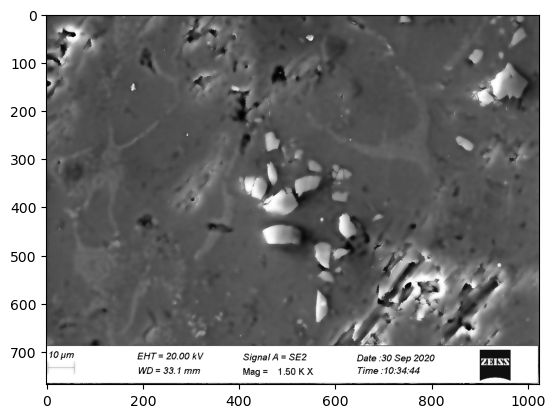

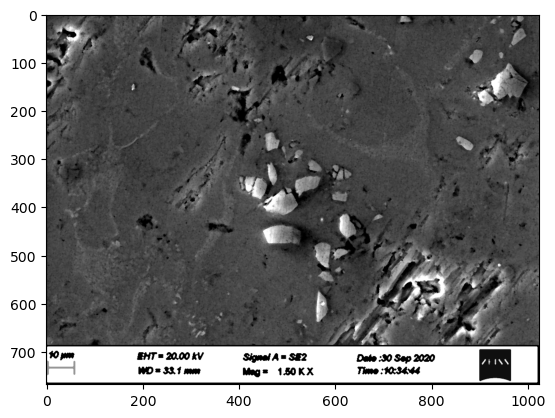

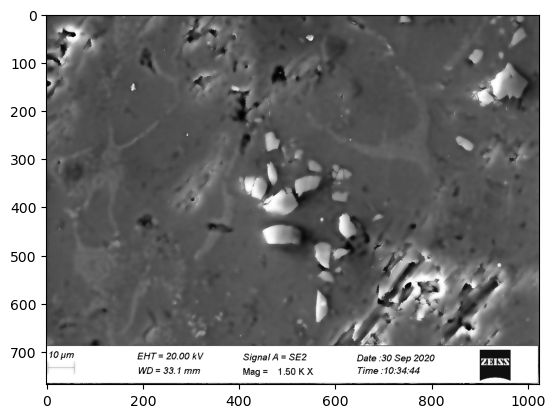

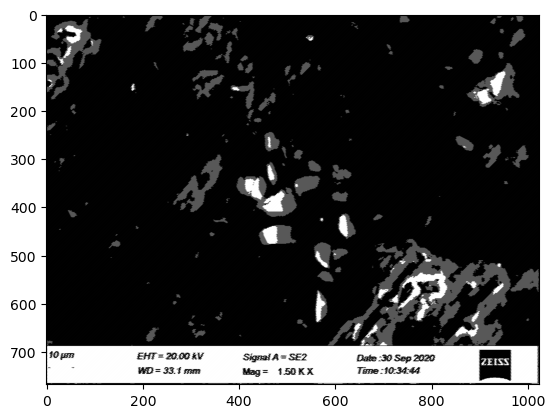

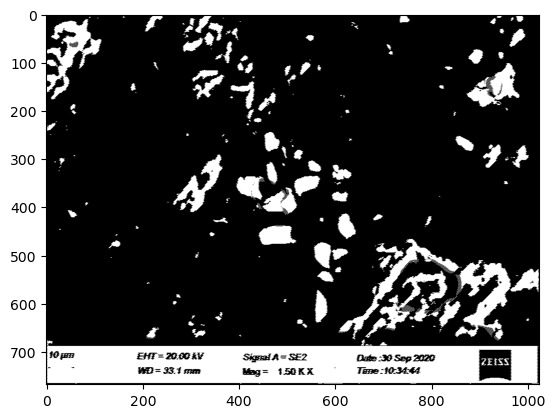

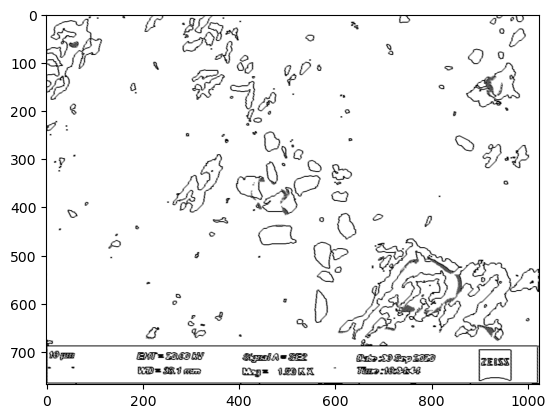

In [11]:
img1 = o3
imge = morph(img)
imgo = otsu(o3)
imgk = color_quantization(imgo[0], k=3)
# line_size, blur_value = 1023,-20
line_size, blur_value = 91,-10
img2 = edge_mask(imgk, line_size, blur_value)
img3 = sobel(img2)
# img3=(img3).astype(np.uint8)




# plt.imshow(canny_output, cmap = 'gray')
# plt.show()
plt.imshow(img1, cmap = 'gray')
plt.show()
plt.imshow(imge, cmap = 'gray', norm = NoNorm())
plt.show()
plt.imshow(imgo[0], cmap = 'gray')
plt.show()
plt.imshow(imgk, cmap = 'gray')
plt.show()
plt.imshow(img2, cmap = 'gray')
plt.show()
plt.imshow(img3, cmap = 'binary')
plt.show()

247.17011128775835


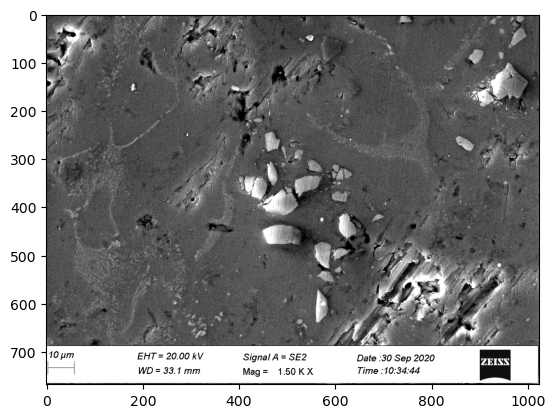

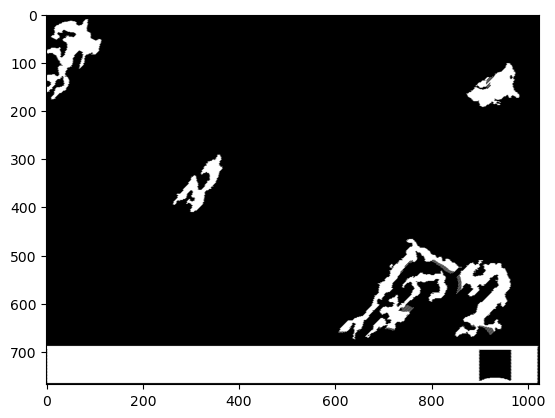

In [18]:

# # # Load the binary image
# # img = cv2.imread('binary_image.png', cv2.IMREAD_GRAYSCALE)

# # # Threshold the image
# ret, thresh = cv2.threshold(img2, 127, 255, cv2.THRESH_BINARY)

# # Find the contours of the objects
# contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# pi = math.pi

# ratio_list = []

# no_objects = 0
# ratio_list = []
# new_contours = []
# for cnt in contours:
#     perimeter = cv2.arcLength(cnt, True)
#     area = cv2.contourArea(cnt)
#     ratio_list.append(area)
#     if area > 3147 :
#         new_contours.append(cnt)

# mean_ratio = np.mean(ratio_list)
# print(mean_ratio)

# # Create a new binary image with the filtered contours
# new_img = np.zeros(img.shape, dtype=np.uint8)
# cv2.drawContours(new_img, new_contours, -1, (255, 255, 255), cv2.FILLED)

# # Display the original and filtered images
# plt.imshow(img, cmap = 'gray')
# plt.show()
# plt.imshow(new_img, cmap = 'gray')
# plt.show()


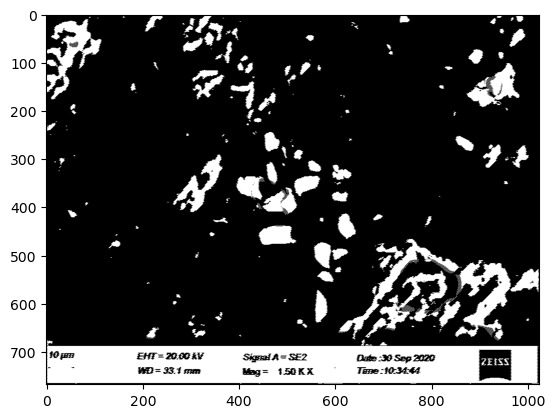

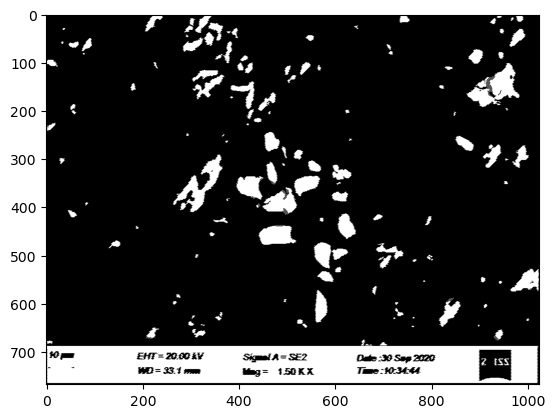

In [63]:

# # Load the binary image
# img = cv2.imread('binary_image.png', cv2.IMREAD_GRAYSCALE)

# # Threshold the image
ret, thresh = cv2.threshold(img2, 0, 255, cv2.THRESH_BINARY)

# Find the contours of the objects
contours_touple, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contours = list(contours_touple)

ratio_list = []
ratio_list = []
removed_contours = []
new_contours = []

dc_contours = copy.deepcopy(contours)

for cnt in contours:
    perimeter = cv2.arcLength(cnt, True)
    area = cv2.contourArea(cnt)
    if area !=0 :
        ratio = (perimeter**2) / area
        ratio_list.append(ratio)
    else :
        ratio_list.append(0)
        
countr = 0
sumr = 0
for i in ratio_list:
    if i != 0:
        sumr+=i
        countr+=1
        
meanr = sumr/countr
        
for i, cnt in enumerate(contours):
    if ratio_list[i] <= (max(ratio_list)/3):
        perimeter = cv2.arcLength(cnt, True)
        area = cv2.contourArea(cnt)
        if area>5 and perimeter>5:
            new_contours.append(cnt)

# Create a new binary image with the filtered contours
new_img = np.zeros(img.shape, dtype=np.uint8)
cv2.drawContours(new_img, new_contours, -1, (255, 255, 255), cv2.FILLED)

# Display the original and filtered images
plt.imshow(thresh, cmap = 'gray')
plt.show()
plt.imshow(new_img, cmap = 'gray')
plt.show()

